In [1]:
import os


import numpy as np

from dynamic_programming.policy_iteration import PolicyIteration, PolicyIterationTorch
from dynamic_programming.mdp_model import MDPModel
from dynamic_programming.policy import DPPolicy
from envs.env_creator import env_creator
from base_algorithm.eval_policy import EvalDiscreteStatePolicy
import time
from envs.plot import plot_industrial_benchmark_trajectories

## Load Data and MDP Model

In [2]:
device = 'cpu'
load_path = os.path.join("tmp", "ibqf-out/ibq_samples.npy")
#load_path = os.path.join("tmp", "ibq_samples_50m.npy")
mdp_save_path = 'tmp/dynamic_programming/mdp_model_pi.pkl'
sa_reward = False
samples = np.load(load_path,allow_pickle=True)[()]


print(samples['rewards'].mean())
print(samples['rewards'].size)
samples['rewards'] = samples['rewards'] + np.abs(samples['rewards'].min())
print(samples['rewards'].min())
print(np.unique(samples['obs']).size)

-342.73888027415506
10000000
0.0
1837


In [3]:
start = time.time()
mdp_model = MDPModel(states=samples['obs'], next_states=samples['new_obs'], actions=samples['actions'],
                     rewards=samples['rewards'], dones=samples['dones'], device=device, sa_reward=sa_reward)

end = time.time()
print(end - start)


Computing Reward Function
Computing Transition Model
263.1111891269684


In [4]:
mdp_model.save(mdp_save_path)

In [5]:
mdp_model = MDPModel.load(mdp_save_path)

## Train

In [6]:
mdp_model.reward_function.shape

(1838,)

In [7]:
mdp_model.reward_function

array([2525.7144, 2413.4985, 2503.555 , ..., 2147.0952, 2187.8008,
       2286.02  ], dtype=float32)

6429.633049887681
4303.9381382915135
4126.407769918409
3948.5513567535454
3826.932245167569
3737.693766937511
3712.2211318185327
3688.717512283809
3654.071912688778
3612.3285391099853
3566.404749947207
3518.466071093644
3470.1309822610856
3422.5962296525104
3376.7230836173403
3346.5251604245495
3321.9661992388938
3297.9359488119007
3274.6529099804175
3253.9297933801863
3236.222939831452
3219.0955474110087
3202.582206816005
3187.803929189249
3176.0481594304147
3165.6522406404692
3157.114198147756
3148.457822353652
3139.7185388673824
3130.926849150317
3122.1088928011595
3113.2869530904572
3104.4799105999555
3095.703649964664
3086.9714244844363
3079.3664927968202
3072.707374033722
3066.069735775265
3059.4540531865496
3052.860665521075
3046.2898090009985
3039.7416486031434
3033.2163058592414
3026.7138812610356
3020.234470899857
3013.778177647182
3007.3451175803493
3000.935422541923
2994.549239764805
2988.186729437235
2981.84806097456
2975.5334086251387
2969.2429468998453
2962.976846177102


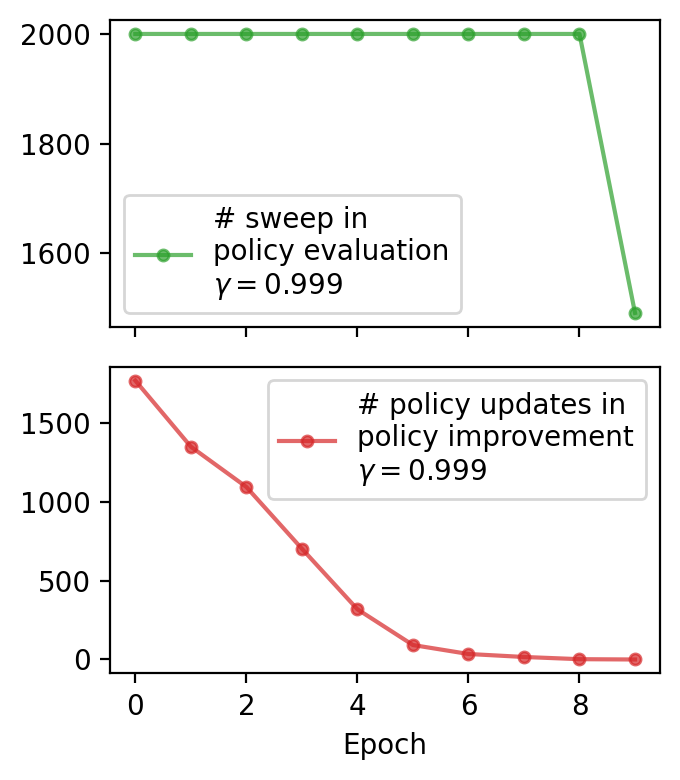

In [8]:
solver = PolicyIteration(mdp_model.reward_function, mdp_model.transition_model, gamma=0.999, sa_reward=sa_reward)
solver.train(total_epochs=100,eval_epochs=2000)
policy_save_path = 'tmp/dynamic_programming/ib_policy.pkl'

trained_policy = DPPolicy(policy_table=solver.policy, state_to_index=mdp_model.state_to_index,
                        index_to_action=mdp_model.index_to_actions)
trained_policy.save(policy_save_path)

In [9]:
print(solver.values)


[2582580.51748553 2582088.91469173 2582630.97729242 ... 2578032.14069506
 2579581.72727941 2579745.22178402]


In [10]:


steps_per_episode = 1000
env_kwargs = {'steps_per_episode': steps_per_episode,'device':device, 'model_path':'state_quantization/model'}

policy = DPPolicy.load(policy_save_path)
algo = EvalDiscreteStatePolicy(policy=policy,env_creator=env_creator,env_kwargs=env_kwargs)

Episode 9 Reward: -225.11613467261333 || New State Found: False


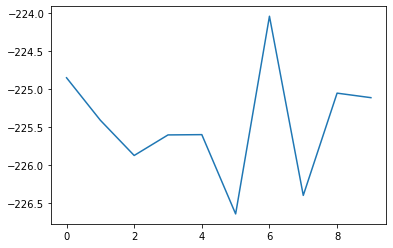

Reward Mean: -225.46116580722523
Reward std : 0.7170465272366429


In [11]:
algo.evaluate(epochs=10)

In [12]:
algo.eval_new_state_found

[False, False, False, False, False, False, False, False, False, False]

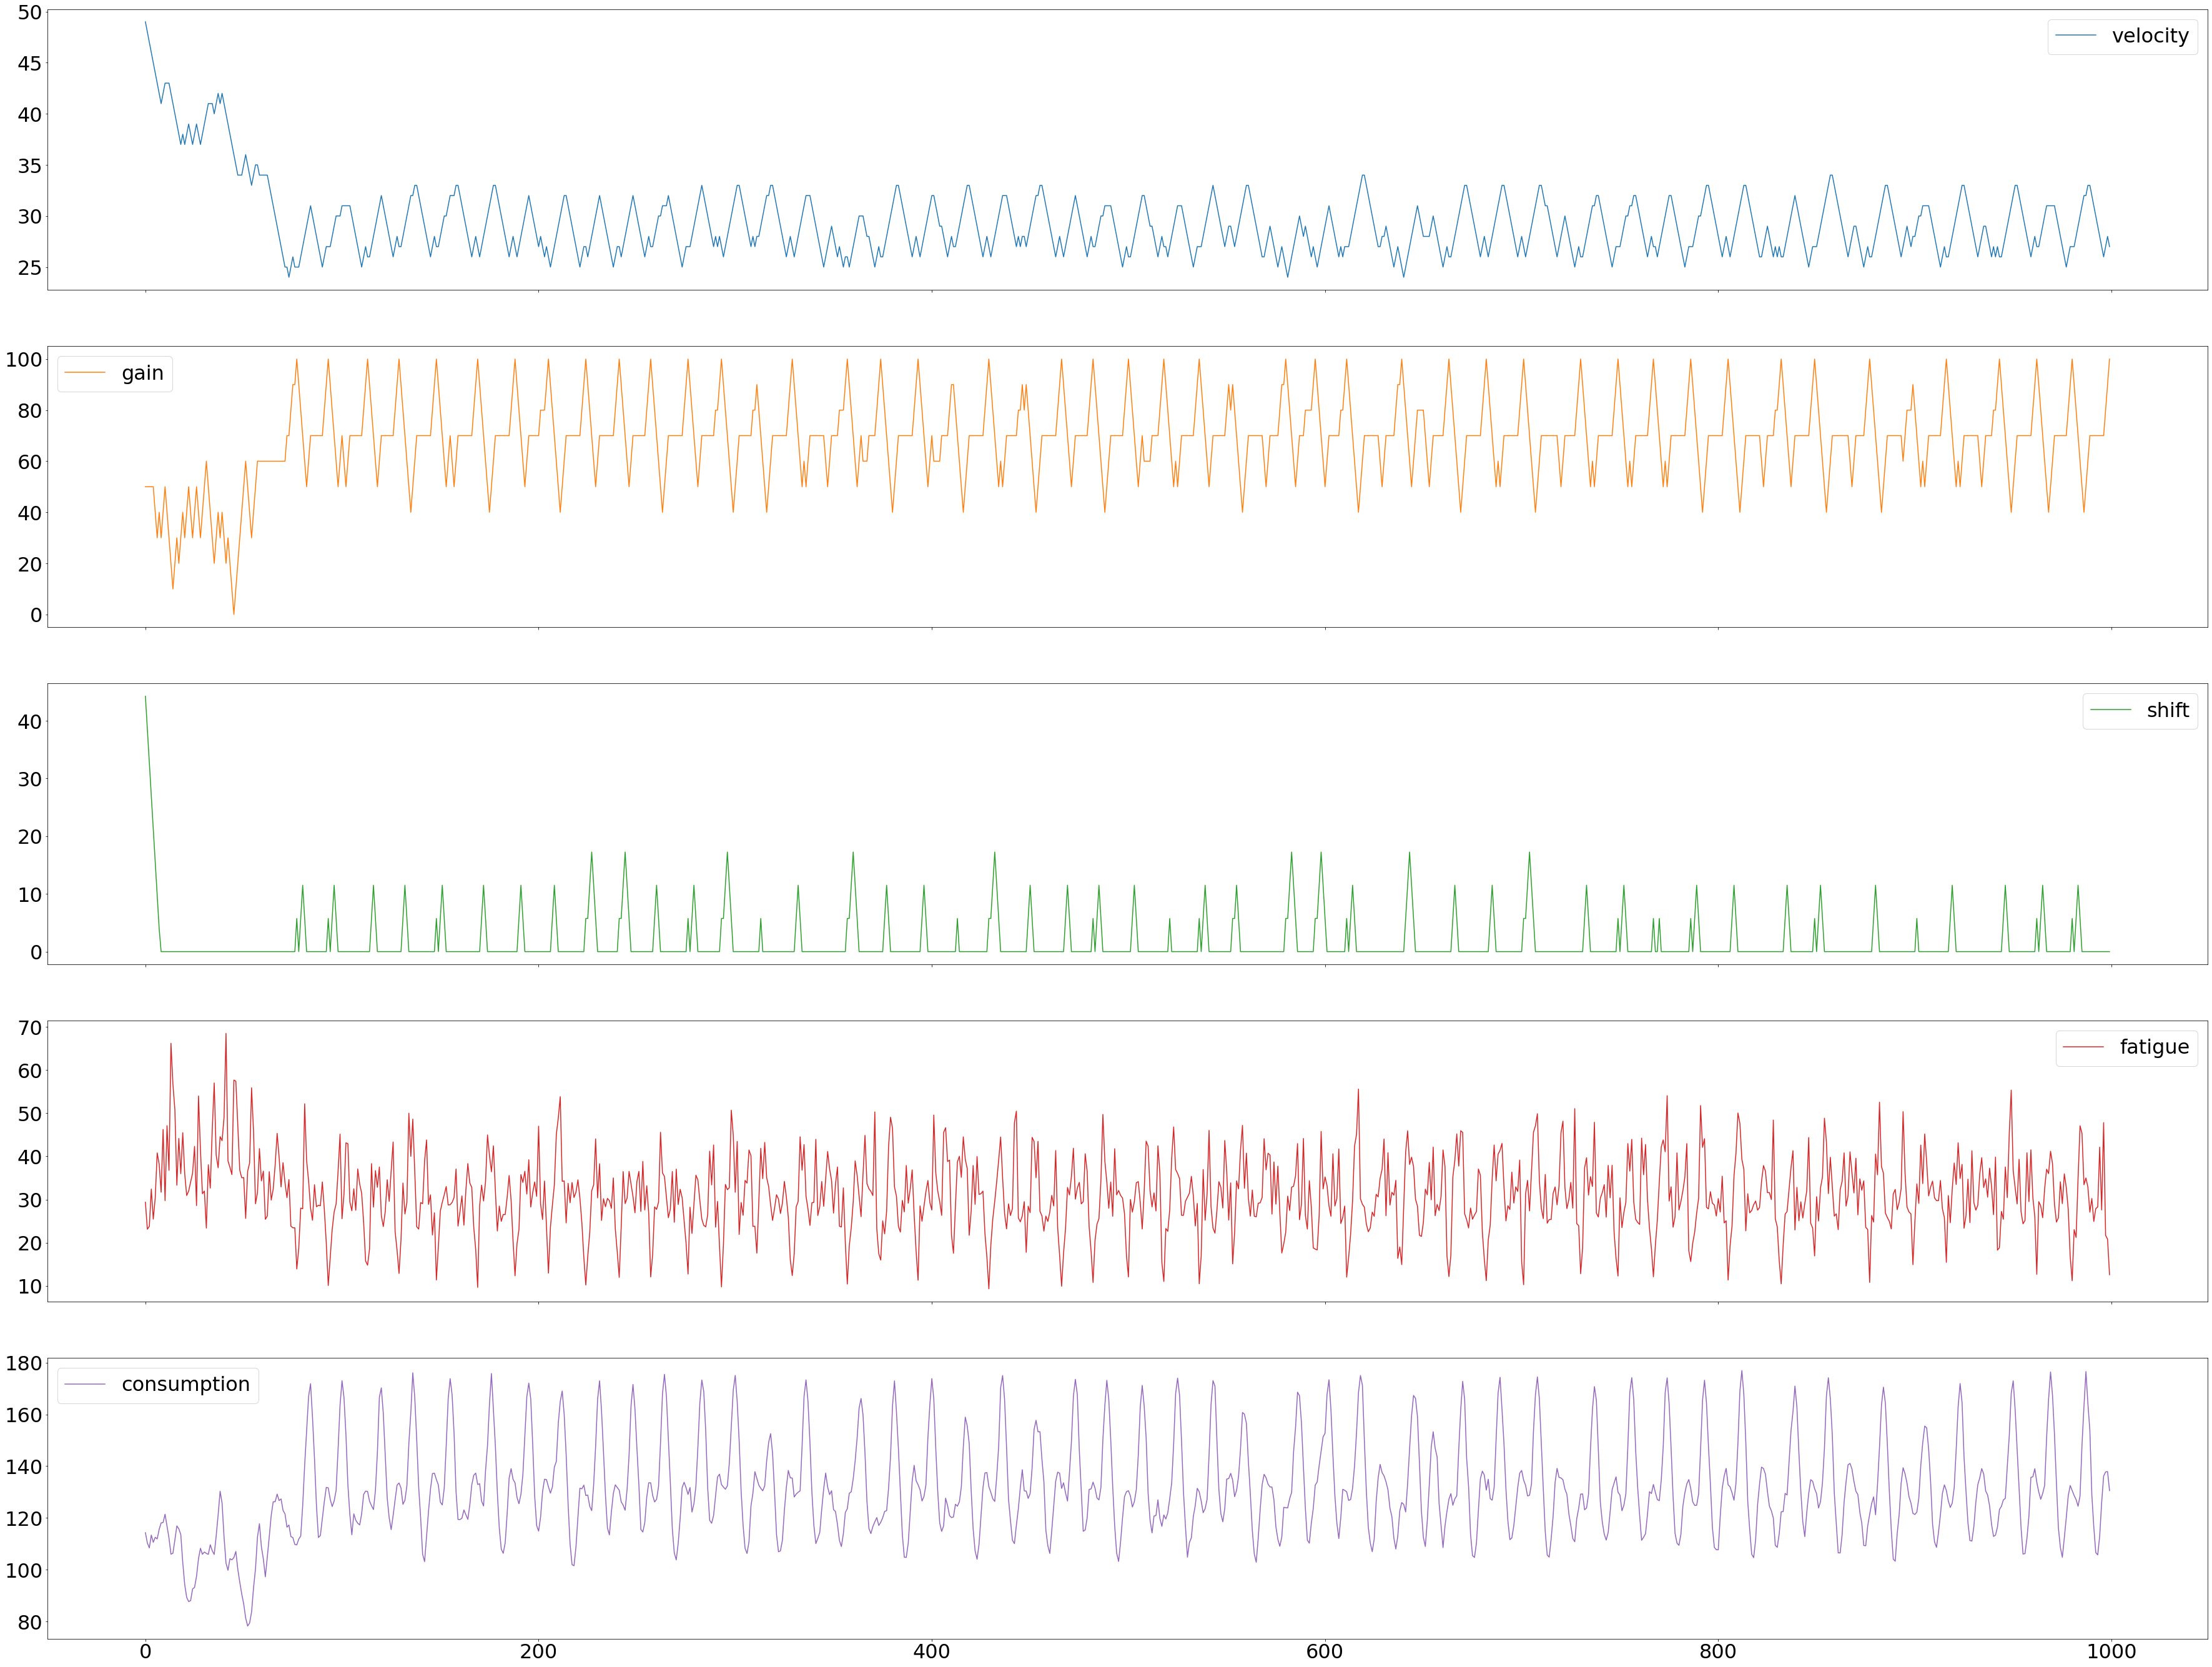

In [13]:
plot_industrial_benchmark_trajectories(algo.eval_trajectories[0]['info'])